In [111]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

import mb_funcs as mb
%load_ext autoreload
%autoreload 2

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
mskcc_loomfile = '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22/tapestri/RA17_22_P1_IGO_11988_B_2/11988_B_2.RA17_22_P1.cells.loom'

with loompy.connect(mskcc_loomfile) as ds:
    print(ds.attrs.keys())
    print(ds.shape)

['CreationDate', 'LOOM_SPEC_VERSION', 'allsites_block', 'chemistry', 'coverage', 'genome_version', 'last_modified', 'mb_loom_version', 'n_reads', 'n_reads_per_cell', 'pipeline_version']
(41833, 479)


In [125]:
ds = loompy.connect(mskcc_loomfile)

In [118]:
ds.close()

#### data overview

In [6]:
for key in ds.attrs.keys():
    print(f'{key}: {ds.attrs[key]}')

CreationDate: 20210602T002756.717729Z
LOOM_SPEC_VERSION: 2.0.1
allsites_block: 8587
chemistry: V2
coverage: 1125
genome_version: hg19
last_modified: 20210602T002756.714716Z
mb_loom_version: 2.2
n_reads: 142385161
n_reads_per_cell: 209274
pipeline_version: 2.0.1


In [7]:
ds.layers.keys()

['', 'AD', 'DP', 'GQ', 'RO']

In [8]:
def generate_heatmap(data):
#     fig, ax = plt.subplots(1,1)
    g = sns.clustermap(data, row_cluster=False, col_cluster=False)
    g.ax_heatmap.set_ylabel('SNVs', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### What is the number of cells, positions, amplicons?

In [9]:
print(f"number of covered positions is {ds.shape[0]}")
print(f"number of cells is {ds.shape[1]}")
print(f"number of amplicons is {len(np.unique(ds.ra['amplicon']))}")
print(f"number of chromosomes is {len(np.unique(ds.ra['CHROM']))}")

number of covered positions is 41833
number of cells is 479
number of amplicons is 186
number of chromosomes is 22


#### Q: what is nonref_cells in row attributes?

In [10]:
ds.ra.keys()

['ALT',
 'CHROM',
 'CLNDEF',
 'COMMON',
 'POS',
 'QUAL',
 'REF',
 'RSID',
 'amplicon',
 'id',
 'nonref_cells']

In [11]:
pd.Series(ds.ra['nonref_cells']).value_counts()

1      14453
0      13926
2       6855
3       3102
4       1350
       ...  
147        1
115        1
83         1
425        1
383        1
Length: 223, dtype: int64

#### position dataframe

In [12]:
df_pos = pd.DataFrame({'pos': list(ds.ra['POS']),
                       'chrom': list(ds.ra['CHROM']),
                       'amplicon': list(ds.ra['amplicon']),
                       'ref': list(ds.ra['REF']),
                       'alt': list(ds.ra['ALT'])})

df_pos['ref_len'] = df_pos['ref'].apply(len)
df_pos['alt_len'] = df_pos['alt'].apply(len)
df_pos['normal'] = (df_pos['ref_len'] == 1) & (df_pos['alt_len'] == 1)

df_pos['index'] = df_pos.index

In [13]:
df_pos

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
0,27057667,1,AMPL50980,C,T,1,1,True,0
1,27057715,1,AMPL50980,A,G,1,1,True,1
2,27057722,1,AMPL50980,A,G,1,1,True,2
3,27057726,1,AMPL50980,TCAG,T,4,1,False,3
4,27057726,1,AMPL50980,T,C,1,1,True,4
...,...,...,...,...,...,...,...,...,...
41828,76777889,X,AMPL70504,CT,C,2,1,False,41828
41829,76777892,X,AMPL70504,T,,1,0,False,41829
41830,76777894,X,AMPL70504,C,,1,0,False,41830
41831,76777895,X,AMPL70504,A,T,1,1,True,41831


In [123]:
df_pos[df_pos['pos'] == 27057726]

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
3,27057726,1,AMPL50980,TCAG,T,4,1,False,3
4,27057726,1,AMPL50980,T,C,1,1,True,4


(array([422.,  36.,  11.,   4.,   4.,   0.,   0.,   0.,   1.,   1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

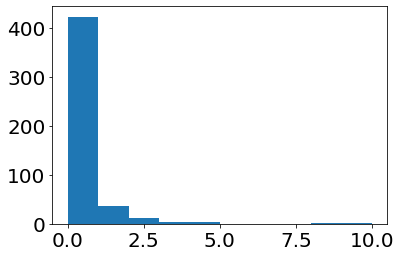

In [131]:
plt.hist(ds.layers['AD'][4,:])

(array([446.,  10.,   8.,  11.,   1.,   1.,   0.,   0.,   1.,   1.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

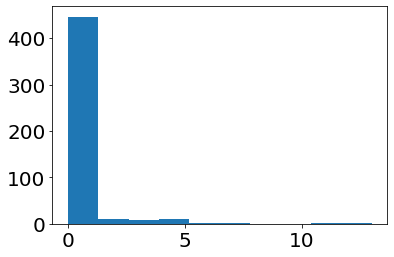

In [132]:
plt.hist(ds.layers['AD'][3,:])

(array([30118.,     0.,     0.,     0.,     0.,  5811.,     0.,     0.,
            0.,    31.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

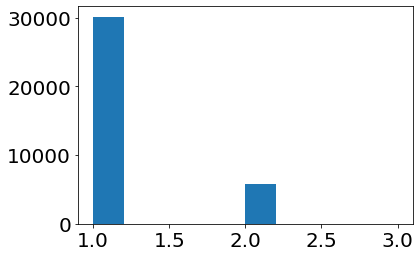

In [122]:
plt.hist(df_pos.groupby(['pos', 'amplicon'])['index'].count().values)

In [145]:
df_unique_pos = df_pos.groupby(['pos', 'amplicon']).last().reset_index()

In [146]:
len(df_unique_pos)

35960

In [147]:
df_unique_pos

,pos,amplicon,chrom,ref,alt,ref_len,alt_len,normal,index
0,346979,AMPL87363,16,T,C,1,1,True,30673
1,346980,AMPL87363,16,G,,1,0,False,30674
2,346981,AMPL87363,16,C,,1,0,False,30675
3,346982,AMPL87363,16,A,T,1,1,True,5673
4,346983,AMPL87363,16,C,,1,0,False,30676
...,...,...,...,...,...,...,...,...,...
35955,198266798,AMPL87266,2,A,,1,0,False,13357
35956,198266799,AMPL87266,2,G,,1,0,False,13358
35957,198266800,AMPL87266,2,G,A,1,1,True,1222
35958,198266801,AMPL87266,2,C,T,1,1,True,1223


#### What is the actual number of positions?

In [17]:
print(f"Total number of positions is {len(df_unique_pos)}")

Total number of positions is 35960


#### What is the number of positions covered in each chromosome?

In [18]:
df_unique_pos['chrom'].value_counts()

17    4276
12    2942
3     2674
2     2669
7     2613
1     2466
X     2347
11    2147
19    1766
18    1459
5     1423
10    1330
6     1279
16    1182
4     1022
9      923
20     862
15     827
8      805
13     586
22     206
14     156
Name: chrom, dtype: int64

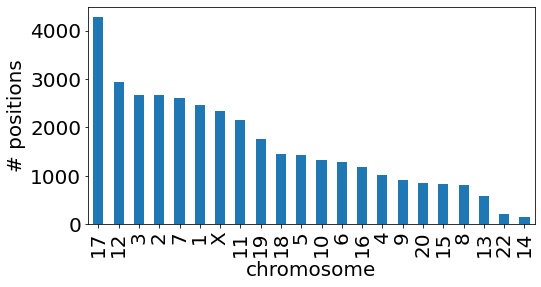

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# positions');

#### what is the number of amplicons in each chromosome?

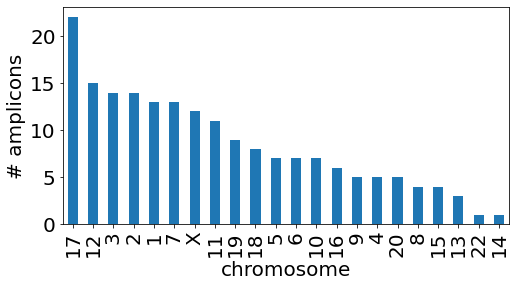

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos.groupby('amplicon').first()['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# amplicons');

#### what is the number of positions in each amplicon

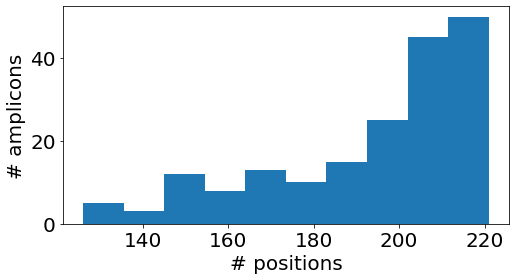

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['amplicon'].value_counts().plot.hist()
plt.gca().set_ylabel('# amplicons');
plt.gca().set_xlabel('# positions');

#### what is the coverage across cells?

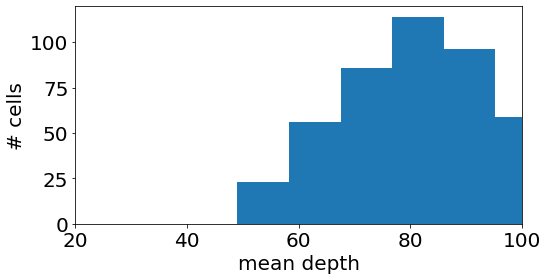

In [22]:
(mean_coverage, ) = ds.layers['DP'].map([np.mean], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(mean_coverage);
plt.gca().set_xlabel('mean depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

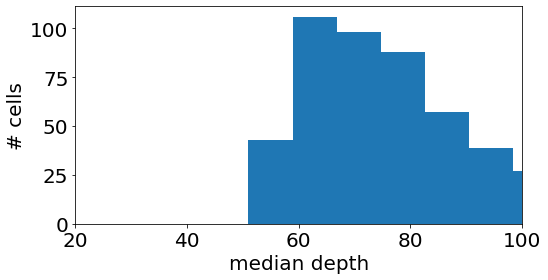

In [23]:
(median_coverage, ) = ds.layers['DP'].map([np.median], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(median_coverage);
plt.gca().set_xlabel('median depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

#### how much does read depth vary within each amplicon?

For each cell $i$ we look at the max read depth $M_{ij}$ and the min read depth $m_{ij}$ across all positions in amplicon $j$. <br>
Then we compute $m_{ij}/M_{ij}$. This is the most extreme factor by which the copy number estimate will vary for positions within amplicon $j$ in cell $i$.

We expect this number to be close to 1 because the read lengths should be comparable with the amplicon lengths. <br>

In [148]:
amplicon_list = list(df_unique_pos['amplicon'].unique())

namplicons = len(amplicon_list)

df_unique_pos = df_unique_pos.sort_values('index')

In [26]:
trim_perc = 0
empty_cells_median = np.zeros((namplicons, 1))

for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values
    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]

    median_depths = np.median(a, axis = 0)
    empty_cells_median[idx] = sum(median_depths == 0)

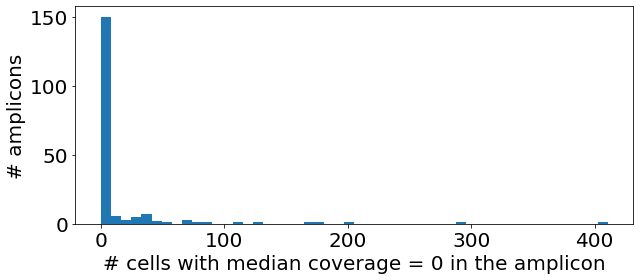

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.hist(empty_cells_median, bins = 50)
plt.gca().set_ylabel('# amplicons', fontsize=20)
plt.gca().set_xlabel('# cells with median coverage = 0 in the amplicon', );

In [114]:
mb_analyzer = mb.analyzer(ds)

rejected 18 cells for amplicon AMPL87363
rejected 19 cells for amplicon AMPL87294
rejected 5 cells for amplicon AMPL87377
rejected 2 cells for amplicon AMPL87244
rejected 5 cells for amplicon AMPL87358


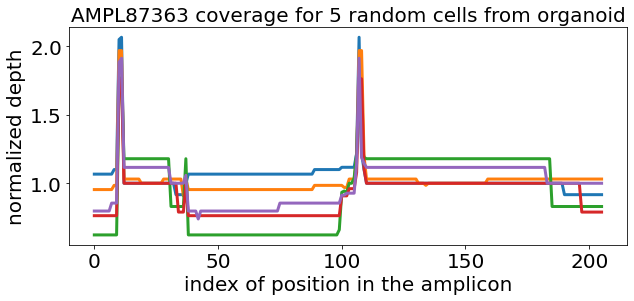

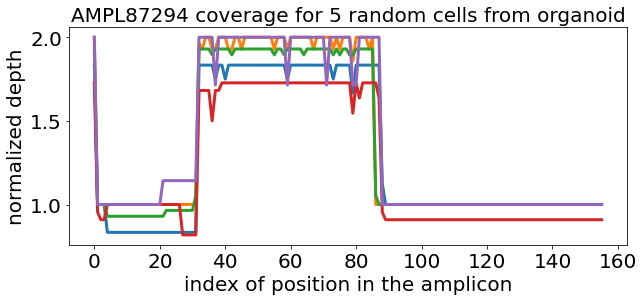

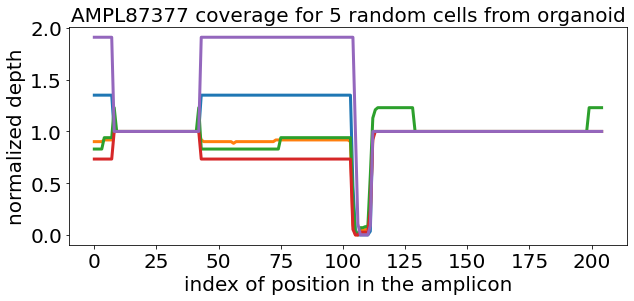

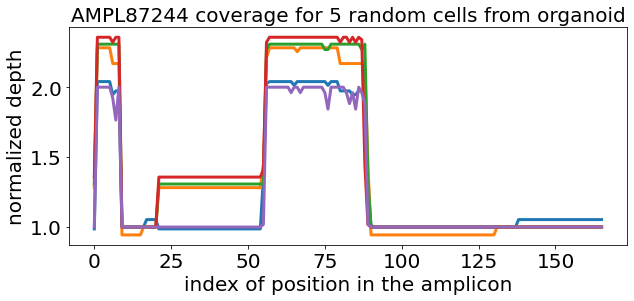

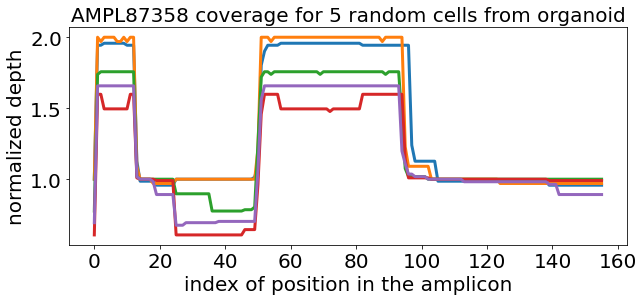

In [115]:
mb_analyzer.plot_amplicon_coverage(amplicon_list[0])
mb_analyzer.plot_amplicon_coverage(amplicon_list[4])
mb_analyzer.plot_amplicon_coverage(amplicon_list[20])
mb_analyzer.plot_amplicon_coverage(amplicon_list[43])
mb_analyzer.plot_amplicon_coverage(amplicon_list[140])

rejected 18 cells for amplicon AMPL87363
rejected 19 cells for amplicon AMPL87294
rejected 5 cells for amplicon AMPL87377
rejected 2 cells for amplicon AMPL87244
rejected 5 cells for amplicon AMPL87358


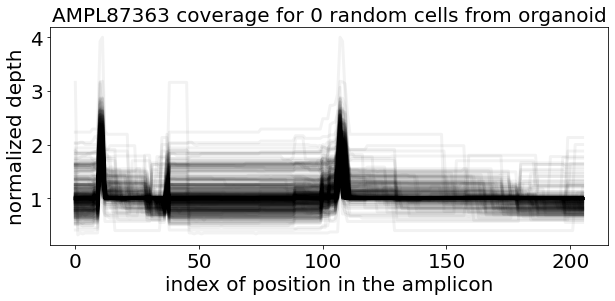

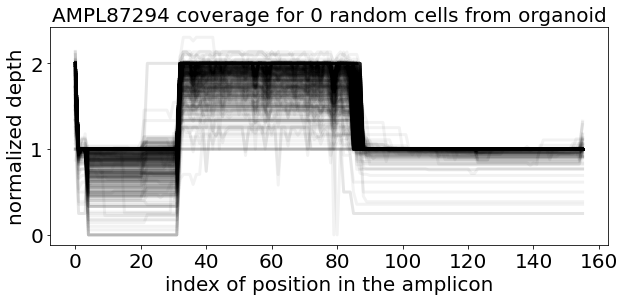

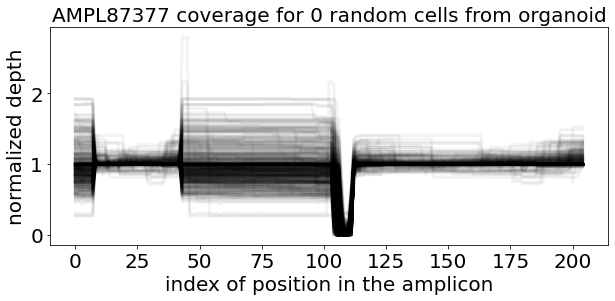

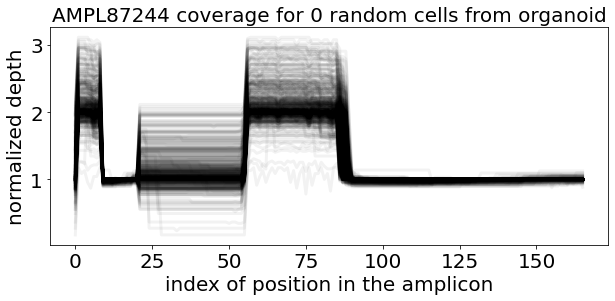

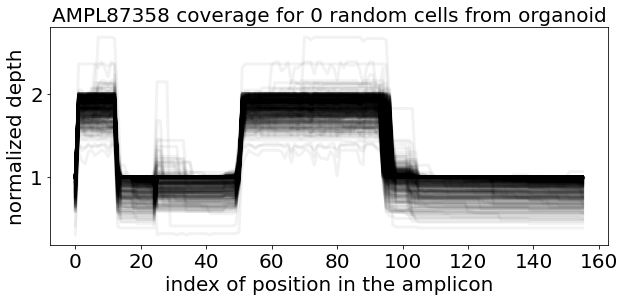

In [116]:
mb_analyzer.plot_amplicon_coverage(amplicon_list[0], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[4], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[20], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[43], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[140], nprobe = 0)

In [30]:
def plot_cell_coverage(cell_idx, nprobe = None, norm_flag = True, trim_perc = 0):

    depth_values = []
    pos_values = []
    prev_npos = 0
    breakpoint_locs = []
    namplicon = len(amplicon_list)
    if nprobe:
        np.random.seed(cell_idx)
        selected_amplicon_list = [amplicon_list[x] for x in np.random.randint(namplicon, size=nprobe)]
    else:
        selected_amplicon_list = amplicon_list.copy()
        
    for amplicon in selected_amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], cell_idx]    


        if norm_flag:
            median_depth =  np.median(a)
            if median_depth == 0:
                a = np.zeros(a.shape)
            else:
                a = a / np.median(a)

        depth_values += list(a)
        pos_values += list(prev_npos + np.arange(npos))
        prev_npos += npos
        breakpoint_locs.append(prev_npos)
        
    fig, ax = plt.subplots(1,1,figsize=(40,4))
    plt.plot(pos_values, depth_values, linewidth=3)
    for idx in range(len(selected_amplicon_list)):
        plt.axvline(breakpoint_locs[idx], color='r')

    plt.gca().set_ylabel('read depth')
    plt.gca().set_xlabel('position index')  
    plt.xlim((0, prev_npos))
    
    if not nprobe:
        plt.title(f"coverage for all amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)
    else:
        plt.title(f"coverage for {nprobe} random amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)

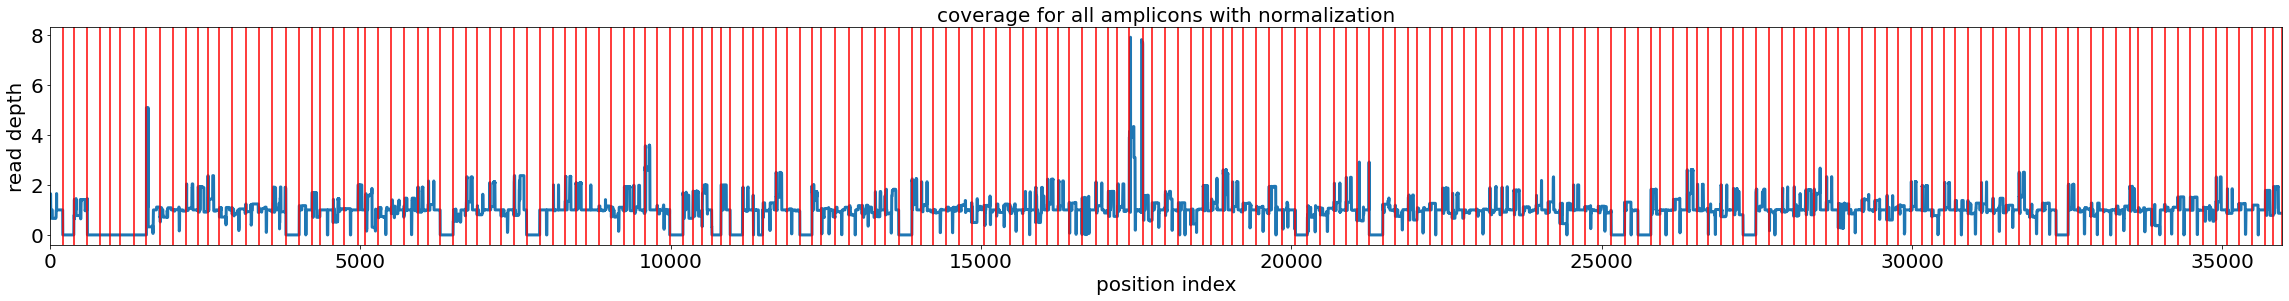

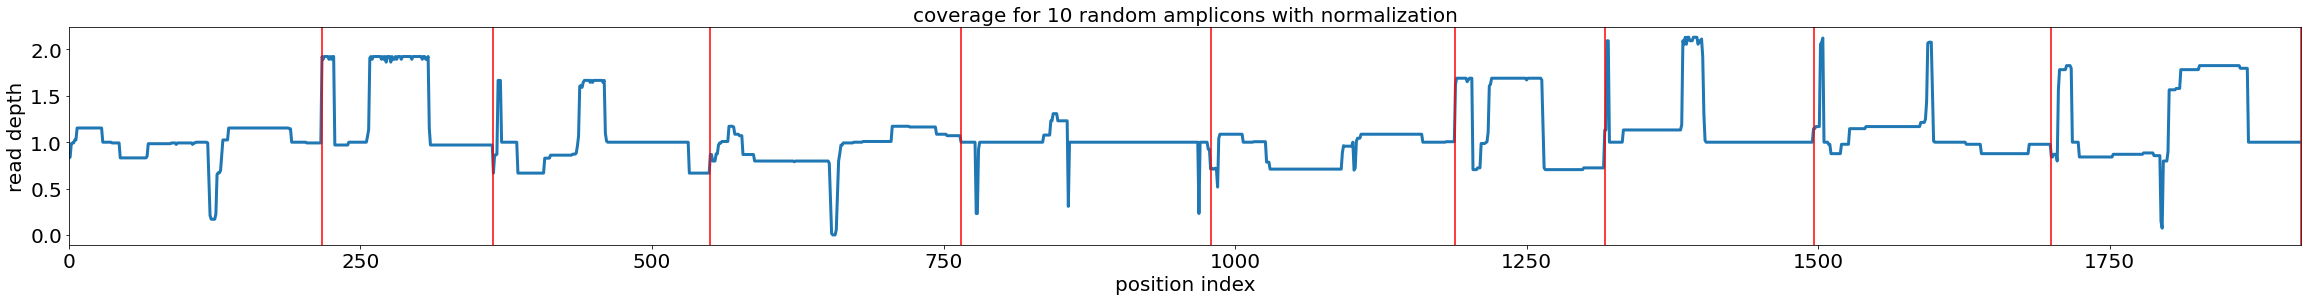

In [31]:
plot_cell_coverage(0)
plot_cell_coverage(0, nprobe = 10)

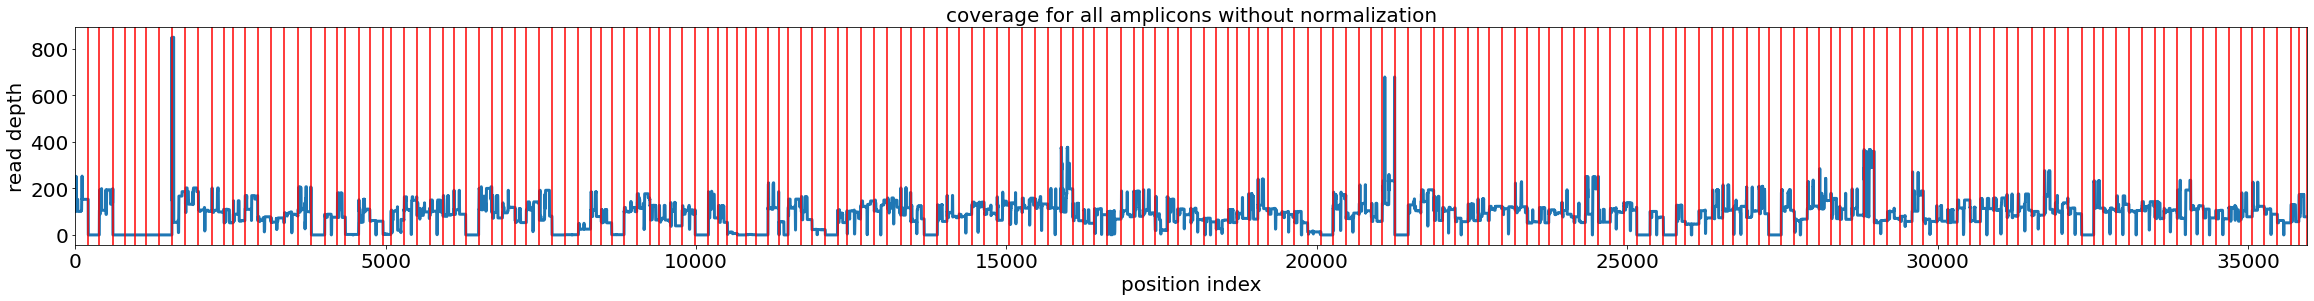

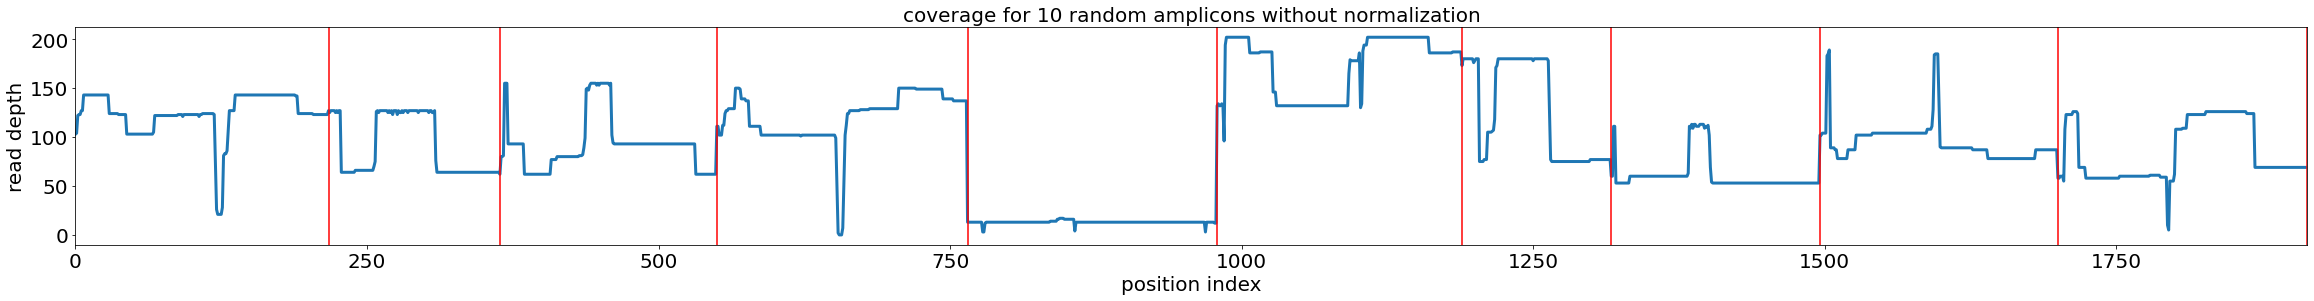

In [32]:
plot_cell_coverage(0, norm_flag=False)
plot_cell_coverage(0, nprobe = 10, norm_flag=False)

In [35]:
probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9]

In [39]:
def plot_quantile_distribution(probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9], trim_perc = 0, read_depth_threshold = 0):

    qrecord = None
    for amplicon in amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        median_depths = np.median(a, axis = 0)
        a_filtered = a[:, median_depths > read_depth_threshold]
        a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)

        if qrecord is not None:
            qrecord = np.hstack((qrecord, np.quantile(a_filtered_normalized, probe_quantile, axis = 0)))
        else:
            qrecord = np.quantile(a_filtered_normalized, probe_quantile, axis = 0)
        
    return qrecord
#     for idx in len(probe_quantile):
#         fig, ax = plt.subplots(1,1,figsize=(6,4))
#         plt.hist(qrecord[idx,:], bins = 20)
#         plt.gca().set_ylabel(f"({probe_quantile[idx]}th quantile)/median")
#         plt.gca().set_xlabel(f"# amplicons across cells")

In [40]:
qrecord = plot_quantile_distribution()

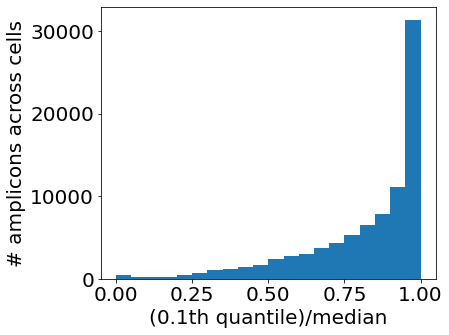

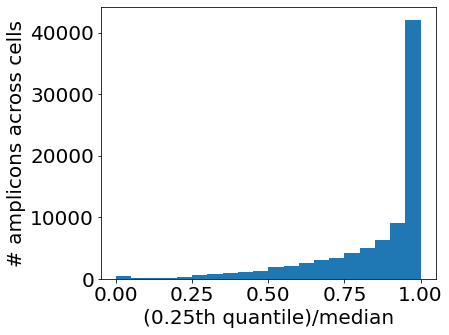

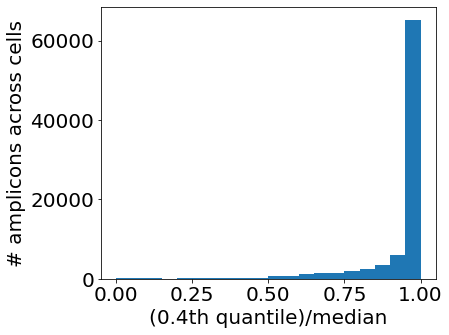

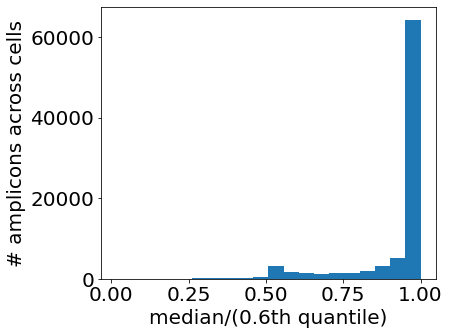

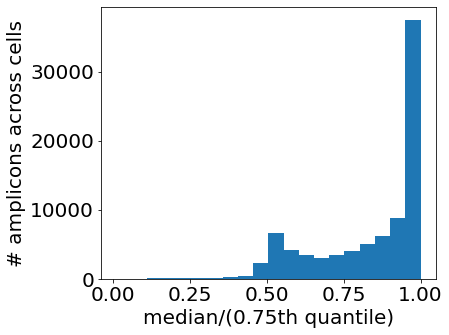

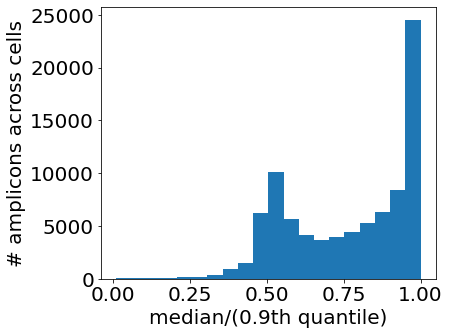

In [41]:
for idx in range(len(probe_quantile)):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    if probe_quantile[idx] > 0.5:
        plt.hist(np.reciprocal(qrecord[idx,:]), bins = 20)
        plt.gca().set_xlabel(f"median/({probe_quantile[idx]}th quantile)")
    else:
        plt.hist(qrecord[idx,:], bins = 20)
        plt.gca().set_xlabel(f"({probe_quantile[idx]}th quantile)/median")
    plt.gca().set_ylabel(f"# amplicons across cells")
#     if probe_quantile[idx] > 0.5:
#         plt.xlim((1,15))

In [42]:
def get_read_depth_heatmap(amplicon_threshold = 0, trim_perc = 0, read_depth_threshold = 0):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]

    return read_depth

In [43]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0, read_depth_threshold = 0)

In [45]:
# np.median(normalized_read_depth, axis = 1).shape

In [46]:
read_depth.shape

(186, 479)

In [47]:
np.sum(read_depth, axis = 0).shape

(479,)

In [48]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 40.75, 'cells')

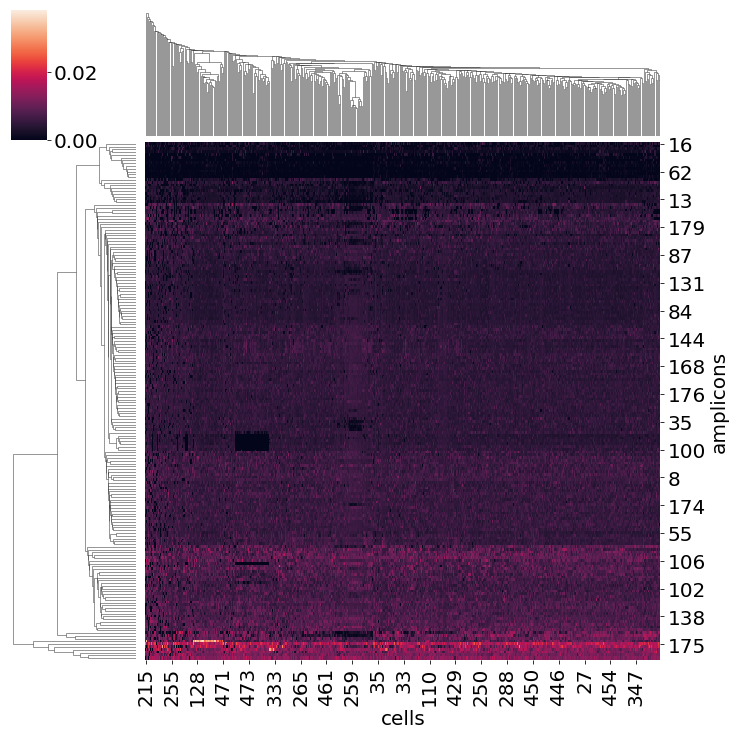

In [49]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [50]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

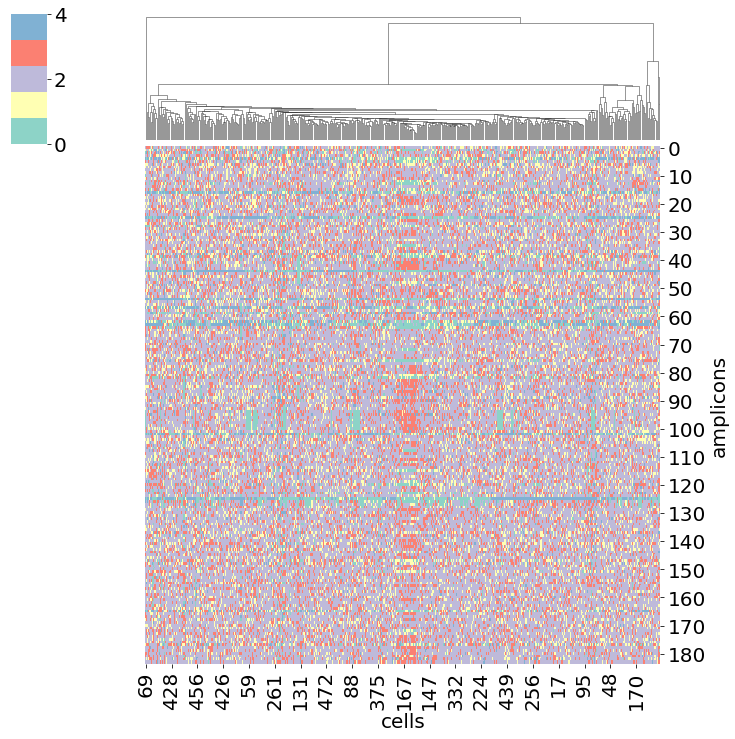

In [51]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=False, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [52]:
relative_normalized_read_depth.shape

(184, 479)

**We filter the cells with low coverage this time**

In [53]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0.8, read_depth_threshold = 10)

In [54]:
read_depth.shape

(186, 478)

In [55]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 40.75, 'cells')

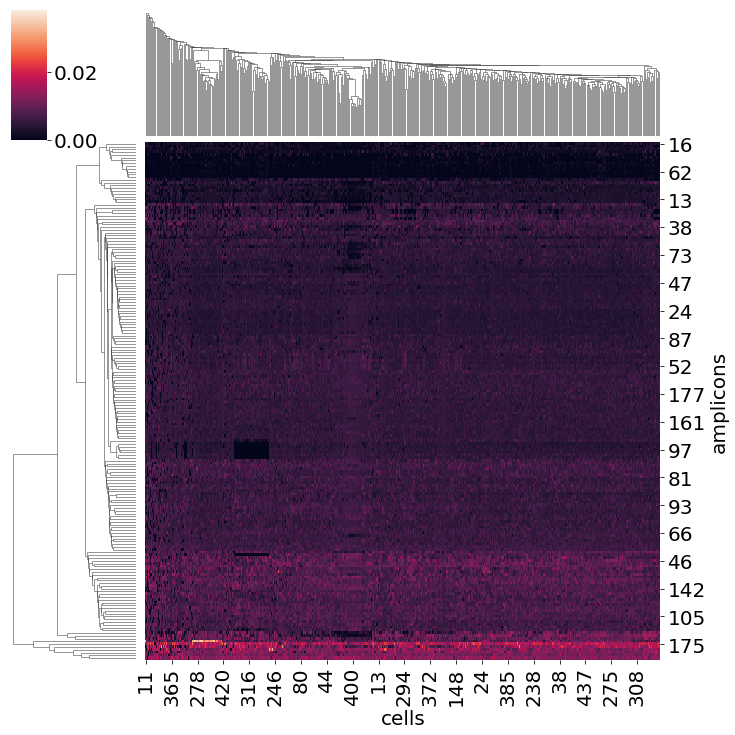

In [56]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [57]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

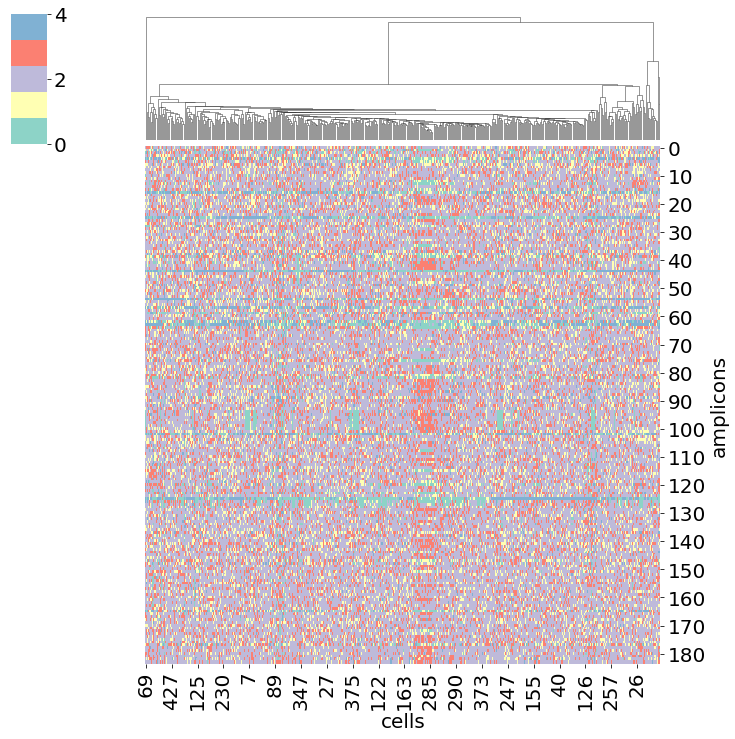

In [58]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=False, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### can we extracat normal cells?

we will try to use SNVs for this

In [149]:
def get_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove positions with max vaf less than vaf_threshold
    return vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]

In [150]:
vaf_mat = get_vaf_matrix(vaf_threshold = 0.2) # a bit more strict with the vaf_threshold here

In [151]:
vaf_mat.shape

(177, 479)

Text(0.5, 40.75, 'cells')

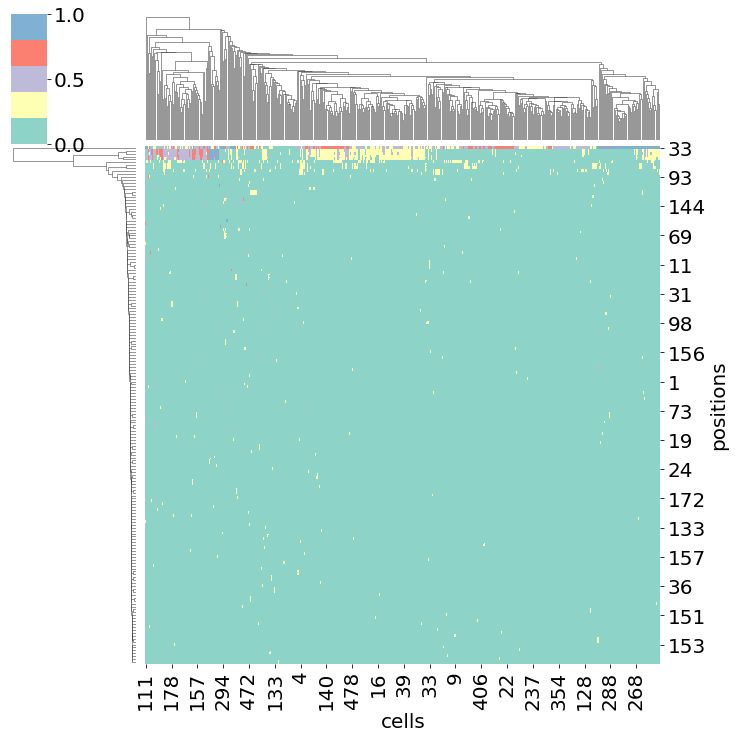

In [152]:
g = sns.clustermap(vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [156]:
filtered_vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) >= 0.1, :]

In [157]:
filtered_vaf_mat.shape

(5, 479)

Text(0.5, 40.75, 'cells')

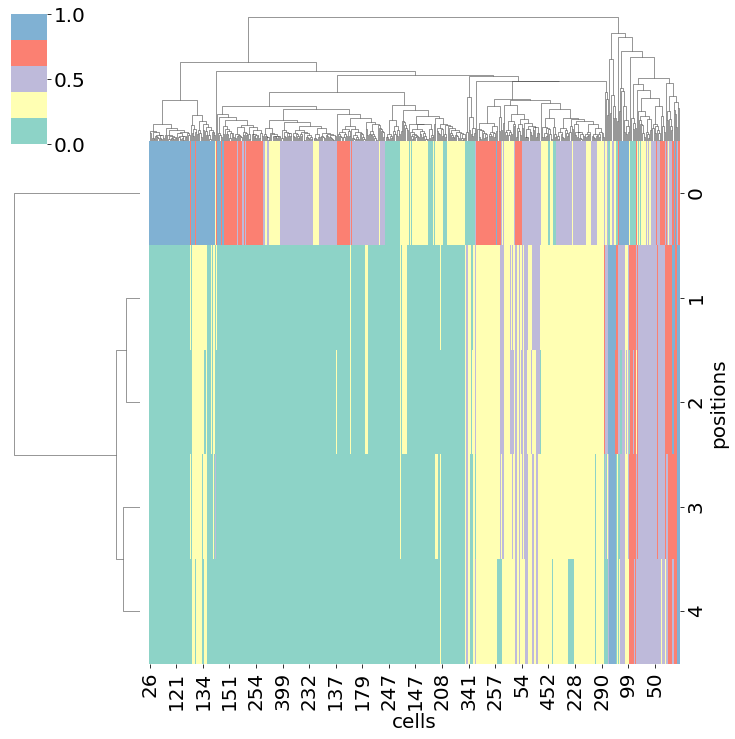

In [158]:
g = sns.clustermap(filtered_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

What are these positions that are mutated in all the cells? Could it be SNPs? <br>
**TODO: download dbsnp database and cross-reference those positions** <br>
Quick fix: remove positions wtih median VAF across all cells more than 0.1

In [159]:
vaf_threshold = 0.1
filtered_vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) <= vaf_threshold, :]

In [160]:
filtered_vaf_mat.shape

(172, 479)

Text(0.5, 40.75, 'cells')

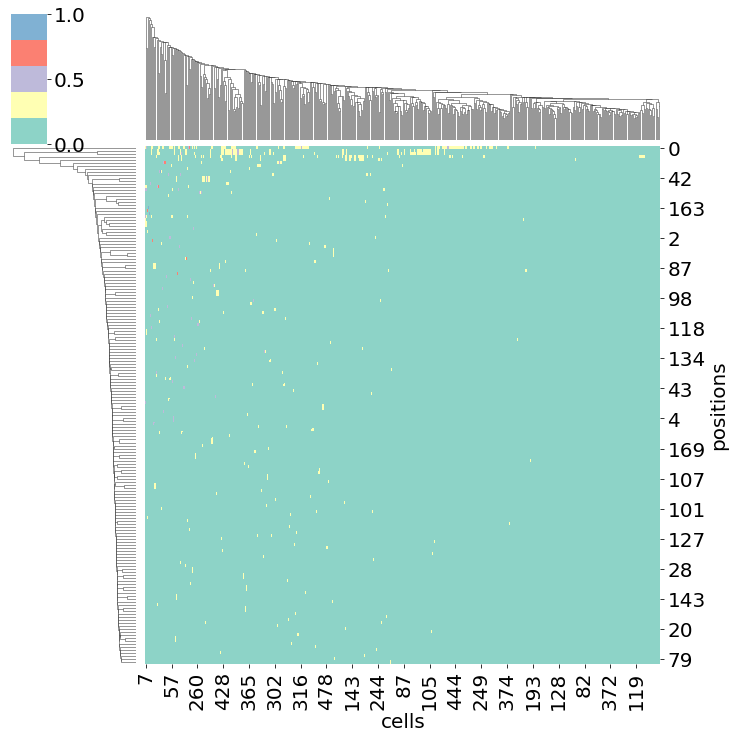

In [161]:
g = sns.clustermap(filtered_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

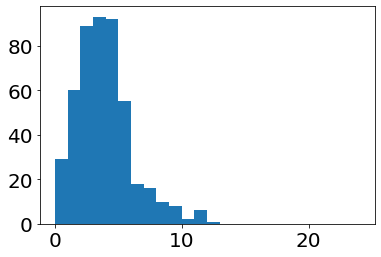

In [162]:
plt.hist(np.sum(filtered_vaf_mat > vaf_threshold, axis = 0), bins = np.arange(25));

In [163]:
print(f'tentative number of normal cells: {sum(np.sum(filtered_vaf_mat > vaf_threshold, axis = 0) == 0)}')

tentative number of normal cells: 29


**Plan: Use these normal cells to normalize total read counts and get copy numbers**

In [164]:
def get_normal_cell_indices(read_depth_threshold = 10, vaf_threshold = 0.1):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove uninformative positions
    vaf_mat = vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]
    
    # remove likely SNP positions
    vaf_mat = vaf_mat[np.median(vaf_mat, axis = 1) <= vaf_threshold, :]
    
    # count number of positions with VAF over the thershold for each cell
    position_count = np.sum(filtered_vaf_mat > vaf_threshold, axis = 0)
    
    return np.where(position_count == 0)[0]

In [165]:
normal_cell_indices = get_normal_cell_indices()

In [166]:
normal_cell_indices.shape

(29,)

In [167]:
normal_cell_indices

array([ 16,  22,  69, 104, 115, 119, 124, 126, 131, 146, 161, 167, 175,
       182, 199, 209, 219, 225, 277, 292, 293, 314, 329, 339, 361, 367,
       385, 412, 448])

**Trying out these normal cells for read count normalization!**

In [168]:
def get_relative_read_depth(normal_cell_indices, amplicon_threshold = 0.8, trim_perc = 0, read_depth_threshold = 10):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # remove amplicons with median read depth acorss all cells equal to 0
    read_depth = read_depth[np.median(read_depth, axis = 1) > 0, :]
    
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    normal_normalized_read_depth = normalized_read_depth[:, normal_cell_indices]
    normal_normalized_read_depth_median = np.median(normal_normalized_read_depth, axis=1)[:, None]
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]
    # normalize the read dpeth in each cell by the total number of reads in that cell
    normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]
    # further normalize by the median read count of each amplicon in the normal cells
    relative_normal_normalized_read_depth = normalized_read_depth / normal_normalized_read_depth_median
    
    return relative_normal_normalized_read_depth

In [169]:
relative_normal_normalized_read_depth = get_relative_read_depth(normal_cell_indices)

In [170]:
relative_normal_normalized_read_depth.shape

(184, 478)

Text(0.5, 40.75, 'cells')

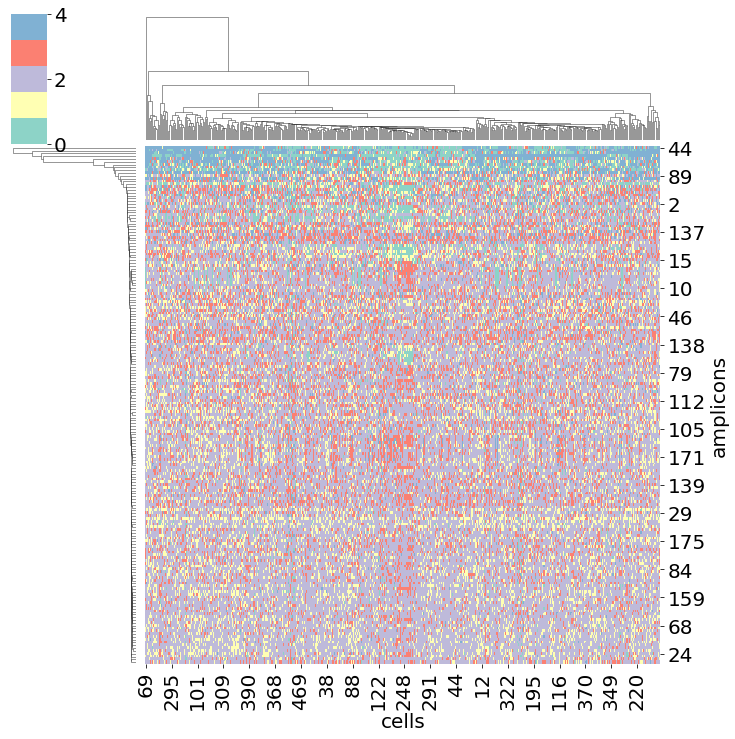

In [171]:
g = sns.clustermap(relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [172]:
relative_normal_normalized_read_depth = get_relative_read_depth(normal_cell_indices, amplicon_threshold=0, read_depth_threshold=0)

Text(0.5, 40.75, 'cells')

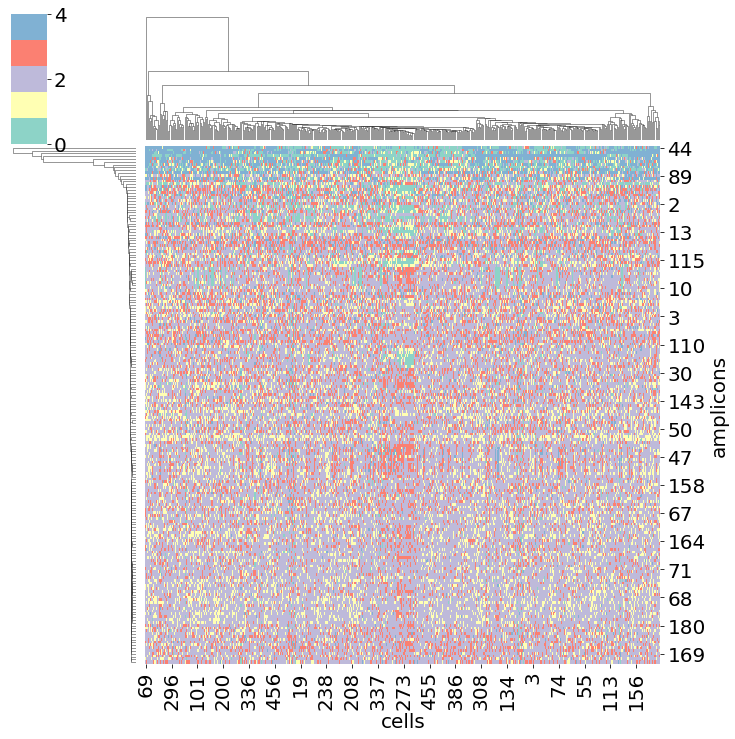

In [173]:
g = sns.clustermap(relative_normal_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### construct condensed VAF matrix

In [174]:
def get_condensed_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.1, presence_threshold = 0.05):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # remove positions with total read depth less than read_depth_threshold
        b = b[np.min(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.min(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
        else:
            vaf_mat = b / a

    # remove positions with max vaf less than vaf_threshold
    vaf_mat = vaf_mat[np.max(vaf_mat, axis = 1) >= vaf_threshold, :]
    
    # remove positions with vaf less than vaf_threshold in less than presense_threshold fraction of the cells
    ncells = vaf_mat.shape[1]
    vaf_threshold_cell_count = (vaf_mat >= vaf_threshold).sum(axis = 1)
    return vaf_mat[vaf_threshold_cell_count >= presence_threshold*ncells, :]

In [175]:
condensed_vaf_mat = get_condensed_vaf_matrix() 

In [176]:
condensed_vaf_mat.shape

(14, 479)

Text(0.5, 40.75, 'cells')

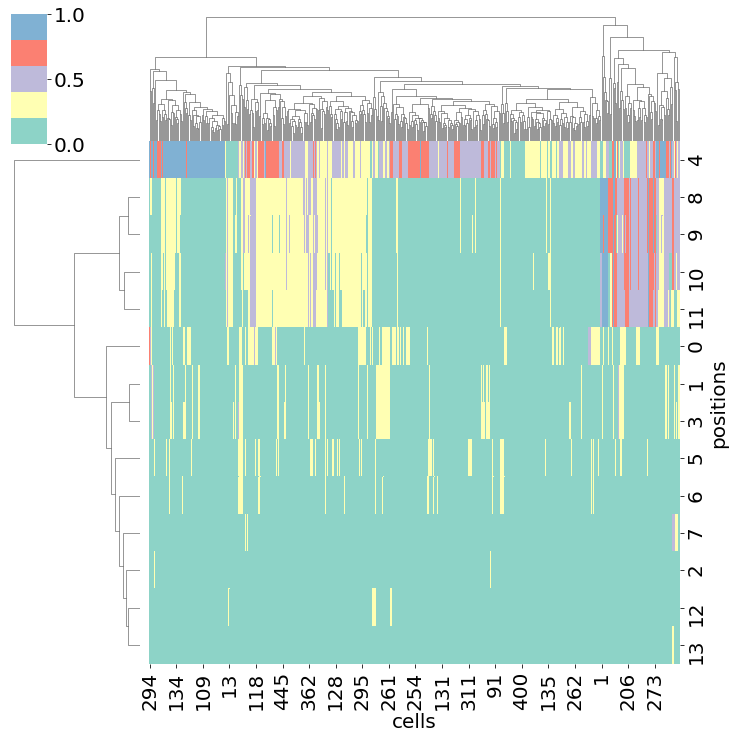

In [177]:
g = sns.clustermap(condensed_vaf_mat, row_cluster=True, col_cluster=True, vmin=0, vmax=1, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)